# Initial Conditions Generation

This notebook demonstrates how to generate Gaussian random fields as initial conditions for cosmological simulations. These fields serve as the starting point for gravitational evolution in field-level inference.

**Contents:**
1. Setup and cosmology definition
2. Power spectrum computation
3. Gaussian random field generation
4. Validation: visual inspection and P(k) recovery

**Requirements:** JAX with GPU support (optional but recommended)

In [2]:
from functools import partial

import jax
import jax.numpy as jnp
import jax.random as jr
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpy as np

from desi_cmb_fli.bricks import lin_power_interp, lin_power_mesh
from desi_cmb_fli.metrics import spectrum
from desi_cmb_fli.utils import rg2cgh

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"Using device: {jax.devices()[0].device_kind}")

JAX version: 0.8.0
JAX devices: [CpuDevice(id=0)]
Using device: cpu


## 1. Define Cosmology

We use a Planck-like ΛCDM cosmology for demonstration.

In [3]:
# [Planck 2018 VI](https://arxiv.org/abs/1807.06209) Table 2 final column (best fit)
Planck18 = partial(
    jc.Cosmology,
    # Omega_m = 0.3111
    Omega_c=0.2607,
    Omega_b=0.0490,
    Omega_k=0.0,
    h=0.6766,
    n_s=0.9665,
    sigma8=0.8102,
    w0=-1.0,
    wa=0.0,
)

cosmo = Planck18()

## 2. Compute Linear Matter Power Spectrum

/pscratch/sd/j/jhawla/envs/desi-cmb-fli/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:125: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


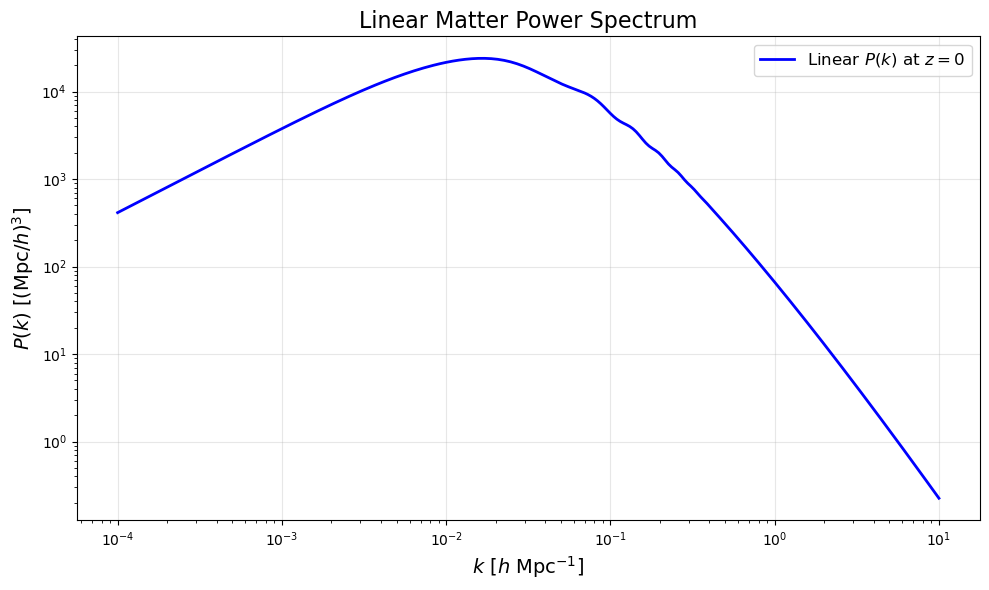

Power spectrum range: P(k_min) = 4.13e+02, P(k_max) = 2.26e-01


In [4]:
# Define k-range: from large scales (small k) to small scales (large k)
k_modes = jnp.logspace(-4, 1, 256)  # h/Mpc, from ~0.001 to 10

# Interpolate linear P(k) at z=0
power_interp = lin_power_interp(cosmo, a=1.0)
pk_linear = power_interp(k_modes)

# Plot
plt.figure(figsize=(10, 6))
plt.loglog(k_modes, pk_linear, "b-", lw=2, label="Linear $P(k)$ at $z=0$")
plt.xlabel(r"$k$ [$h$ Mpc$^{-1}$]", fontsize=14)
plt.ylabel(r"$P(k)$ [$(\mathrm{Mpc}/h)^3$]", fontsize=14)
plt.title("Linear Matter Power Spectrum", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

print(f"Power spectrum range: P(k_min) = {pk_linear[0]:.2e}, P(k_max) = {pk_linear[-1]:.2e}")

## 3. Generate Gaussian Random Field

We generate a 3D density field $\delta(\mathbf{x})$ in a cubic box with periodic boundary conditions.

**Simulation parameters:**
- Box size: 100 Mpc/h (representative of a small cosmological volume)
- Grid resolution: 256³ (production quality; smaller grids for testing)
- Random seed: 1 (for reproducibility)

**Method:**
1. Draw Gaussian white noise in real space
2. Transform to Fourier coefficients with Hermitian symmetry (`rg2cgh`)
3. Apply linear theory transfer function: multiply by $\sqrt{P(k)}$
4. Inverse FFT to obtain real-space density field

**Note:** The field variance will be larger than σ₈ because it includes power from all k-modes, not just the R=8 Mpc/h smoothed field.

In [5]:
# Simulation parameters
box_size = 100.0  # Mpc/h
N = 8  # 2^N grid points per side
mesh_shape = np.array([2**N, 2**N, 2**N])
box_shape = np.array([box_size, box_size, box_size])
seed = 1

print(f"Generating field in {box_size} (Mpc/h)³ box with {mesh_shape} grid...")

# Linear-theory transfer in Fourier space
pmesh = lin_power_mesh(cosmo, mesh_shape, box_shape, a=1.0)
transfer = jnp.sqrt(pmesh)

# Draw Gaussian modes and map them to Hermitian Fourier coefficients
key = jr.PRNGKey(seed)
gaussian_real = jr.normal(key, shape=mesh_shape)
gaussian_k = rg2cgh(gaussian_real)
delta_k = gaussian_k * transfer

# Back to real space
delta_field = jnp.fft.irfftn(delta_k, s=mesh_shape)

print(f"Field shape: {delta_field.shape}")
print(f"Field statistics: mean = {jnp.mean(delta_field):.6f}, std = {jnp.std(delta_field):.6f}")
print(f"Field range: [{jnp.min(delta_field):.4f}, {jnp.max(delta_field):.4f}]")

Generating field in 100.0 (Mpc/h)³ box with [256 256 256] grid...
Field shape: (256, 256, 256)
Field statistics: mean = -0.000000, std = 4.349537
Field shape: (256, 256, 256)
Field statistics: mean = -0.000000, std = 4.349537
Field range: [-22.9043, 22.9833]
Field range: [-22.9043, 22.9833]


## 4. Visualization

### 4.1 2D Slice Through the Field

We visualize a 2D slice at the middle of the box to see the spatial structure.

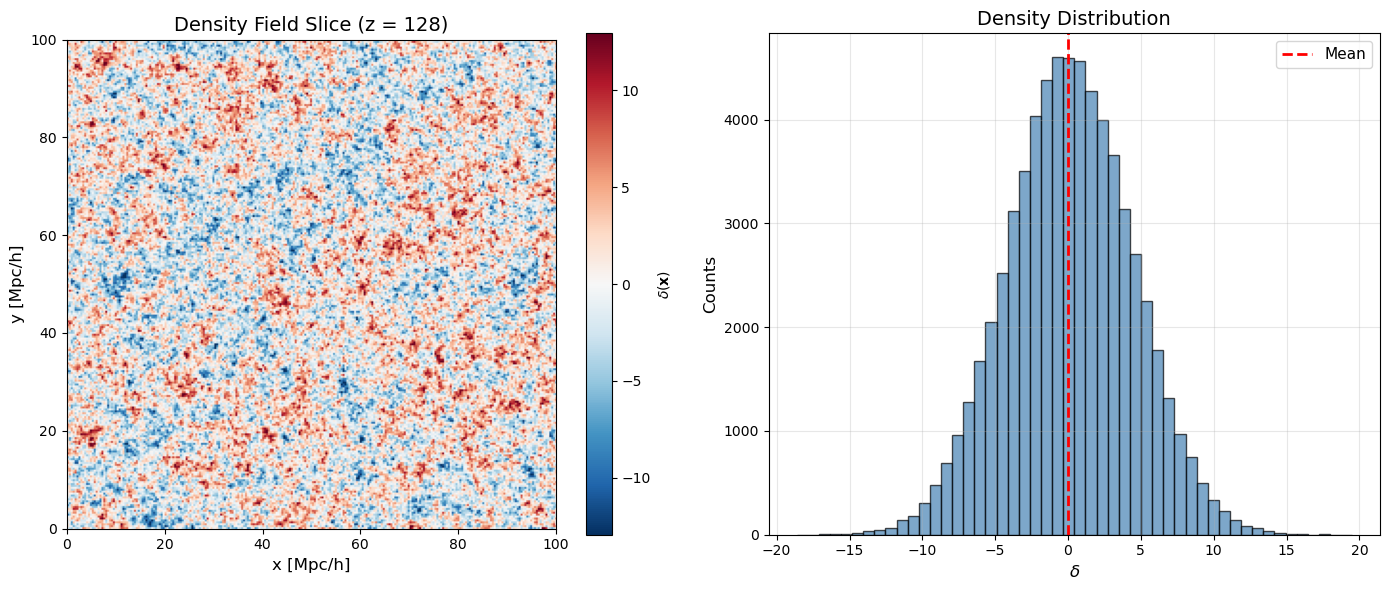

In [6]:
# Extract middle slice along z-axis
slice_z = mesh_shape[2] // 2
delta_slice = np.array(delta_field[:, :, slice_z])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: density slice
im1 = axes[0].imshow(
    delta_slice.T,
    origin="lower",
    cmap="RdBu_r",
    extent=[0, box_size, 0, box_size],
    vmin=-3 * np.std(delta_slice),
    vmax=3 * np.std(delta_slice),
)
axes[0].set_xlabel("x [Mpc/h]", fontsize=12)
axes[0].set_ylabel("y [Mpc/h]", fontsize=12)
axes[0].set_title(f"Density Field Slice (z = {slice_z})", fontsize=14)
plt.colorbar(im1, ax=axes[0], label=r"$\delta(\mathbf{x})$")

# Right: histogram of density values
axes[1].hist(delta_slice.flatten(), bins=50, color="steelblue", alpha=0.7, edgecolor="black")
axes[1].axvline(0, color="red", linestyle="--", linewidth=2, label="Mean")
axes[1].set_xlabel(r"$\delta$", fontsize=12)
axes[1].set_ylabel("Counts", fontsize=12)
axes[1].set_title("Density Distribution", fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Power Spectrum Recovery

To validate the field, we measure $P(k)$ from the generated field and compare it to the input.

In [7]:
print("Measuring power spectrum from generated field...")

n_bins = 100
k_measured, pk_measured = spectrum(
    delta_field,
    box_shape=box_shape,
    kedges=n_bins,
)

print(f"Number of k-bins with modes: {len(k_measured)}")

Measuring power spectrum from generated field...
Number of k-bins with modes: 99
Number of k-bins with modes: 99


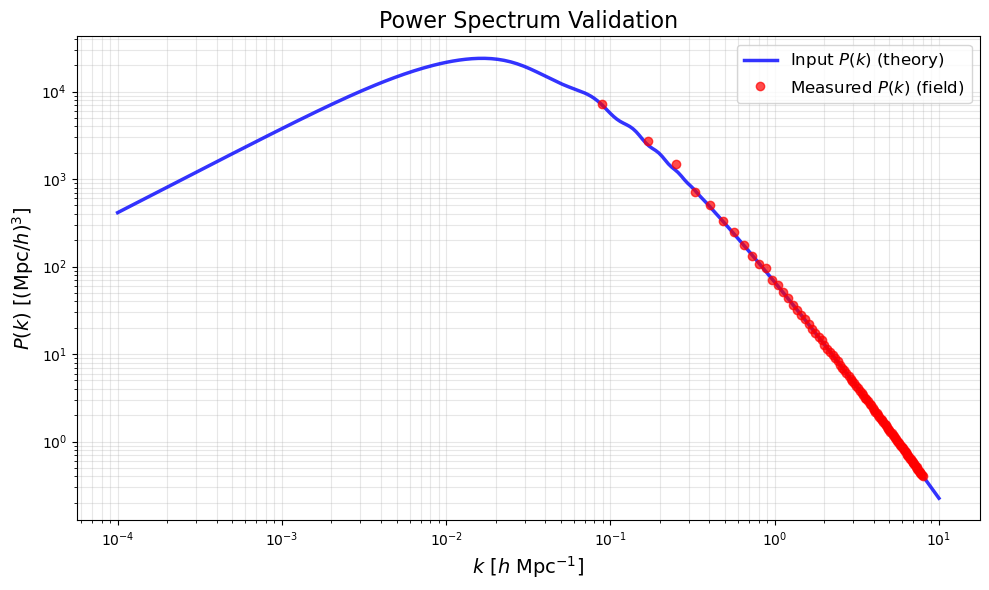


Relative difference in overlap region:
  Mean: 0.003
  Std:  0.025
  Max:  0.177


In [8]:
# Plot comparison
plt.figure(figsize=(10, 6))

k_modes_np = np.asarray(k_modes)
pk_linear_np = np.asarray(pk_linear)
k_measured_np = np.asarray(k_measured)
pk_measured_np = np.asarray(pk_measured)

plt.loglog(k_modes_np, pk_linear_np, "b-", lw=2.5, label="Input $P(k)$ (theory)", alpha=0.8)
plt.loglog(
    k_measured_np, pk_measured_np, "ro", markersize=6, label="Measured $P(k)$ (field)", alpha=0.7
)

plt.xlabel(r"$k$ [$h$ Mpc$^{-1}$]", fontsize=14)
plt.ylabel(r"$P(k)$ [$(\mathrm{Mpc}/h)^3$]", fontsize=14)
plt.title("Power Spectrum Validation", fontsize=16)
plt.grid(True, alpha=0.3, which="both")
plt.legend(fontsize=12, loc="best")
plt.tight_layout()
plt.show()

# Compute residuals where both overlap
k_overlap_mask = (k_measured_np >= k_modes_np.min()) & (k_measured_np <= k_modes_np.max())
if np.count_nonzero(k_overlap_mask) > 5:
    k_overlap = k_measured_np[k_overlap_mask]
    pk_theory_interp = np.interp(k_overlap, k_modes_np, pk_linear_np)
    pk_meas_overlap = pk_measured_np[k_overlap_mask]
    rel_diff = (pk_meas_overlap - pk_theory_interp) / pk_theory_interp
    print("\nRelative difference in overlap region:")
    print(f"  Mean: {rel_diff.mean():.3f}")
    print(f"  Std:  {rel_diff.std():.3f}")
    print(f"  Max:  {np.max(np.abs(rel_diff)):.3f}")

## 5. Summary

✅ **Validation successful:**
- Gaussian random field generated with correct statistical properties (mean ≈ 0)
- Power spectrum recovery: measured P(k) matches input theory